In [1]:
import torch



In [2]:
import torch
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from rigl_torch.models import ModelFactory

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "model"
        self.lin1 = torch.nn.Linear(in_features=10,out_features=100)
        self.lin2 = torch.nn.Linear(in_features=100,out_features=1)
    
    def forward(self, input):
        x = self.lin1(input)
        x = torch.nn.ReLU(x)
        x = self.lin2(x)
        return x
    
    
x= torch.Tensor([x for x in range(10)])
y=torch.Tensor([100])
model = Model()
# out = model(x)

# opt = torch.optim.SGD(
#     params=model.parameters(),
#     lr=0.01,
#     momentum=0.9,
#     weight_decay=0.0005,
# )
# criterion = torch.nn.MSELoss()
# loss = criterion(out, y)
# loss.backward()

# for p in model.parameters():
#     print(p.grad)

In [26]:
score_drop = torch.abs(model.lin1.weight)
score_drop.shape

torch.Size([100, 10])

In [29]:
values, idx = torch.topk(
    score_drop.flatten(),
    k=10,
    dim=-1,
    largest=True,
    sorted=True
)

In [ ]:
drop_mask = 

In [135]:
for name, p in model.named_modules():
    print(p)

Model(
  (lin1): Linear(in_features=10, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=1, bias=True)
)
Linear(in_features=10, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)


In [14]:
max([1,23])

23

In [13]:
import torch

t = torch.Tensor([1,2,3])
m = torch.Tensor([True, True, True])

torch.abs(t[m == False]).max().item()

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [131]:
for m in model.modules():
    print(m.name)

model


AttributeError: 'Linear' object has no attribute 'name'

In [129]:
w = model.lin1.weight
t = torch.Tensor(size=(w.shape))
t[:] = torch.inf
t[]

tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, i

In [114]:
n_prune=
_, sorted_indices = torch.topk(score_drop.view(-1), k=n_prune)
new_values_test = torch.zeros(size=(score_drop.flatten().shape), dtype=torch.bool)
new_values_test[sorted_indices] = True

NameError: name 'n_prune' is not defined

In [113]:
n_total = score_drop.numel()
n_keep = int(n_total * 0.1)
w = model.lin1.weight
_, sorted_indices = torch.topk(score_drop.view(-1), k=n_total)
new_values = torch.where(
    torch.arange(n_total, device=w.device) < n_keep,
    torch.ones_like(sorted_indices),
    torch.zeros_like(sorted_indices),
)
mask1 = new_values.scatter(0, sorted_indices, new_values)
mask1.sum()

tensor(100)

In [41]:
drop_mask = torch.zeros(size=(score_drop.numel(),), dtype=torch.bool)
drop_mask[idx] = True

In [79]:
from functools import reduce

l = [
    [1,2,3],
    [1,2,3],
    [1,2,3],
    [1,2,3],
]


sum([len(sub_list) for sub_list in l])


12

In [71]:
reduce(lambda x,y: print(x), [[1],[2],[5],[4]])

[1]
None
None


In [47]:
idx

tensor([481, 537, 619, 992, 443, 605, 262, 214, 170, 483])

In [49]:
drop_mask = drop_mask.reshape(shape=score_drop.shape)
values


tensor([0.3162, 0.3162, 0.3160, 0.3156, 0.3145, 0.3145, 0.3140, 0.3127, 0.3124,
        0.3117], grad_fn=<TopkBackward0>)

In [50]:
score_drop.flatten()[idx]

tensor([0.3162, 0.3162, 0.3160, 0.3156, 0.3145, 0.3145, 0.3140, 0.3127, 0.3124,
        0.3117], grad_fn=<IndexBackward0>)

In [6]:
model.lin1.weight.shape

torch.Size([100, 10])

In [8]:
model.lin1.weight.ablated = True

In [16]:
model.lin1.weight[0]

tensor([-0.0058,  0.1171, -0.0432,  0.1910,  0.1428, -0.0060, -0.1363,  0.1132,
        -0.2438,  0.0087], grad_fn=<SelectBackward0>)

In [23]:
wide_res = ModelFactory.load_model(model="wide_resnet22", dataset="cifar10")

INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model wide_resnet22/cifar10 using <function get_wide_resnet_22 at 0x7fe1195e8430> with args: () and kwargs: {}


In [38]:
target_types = [
    torch.nn.Conv2d,
    torch.nn.Linear
]



for m in wide_res.modules():
    if type(m) in target_types:
        print(m.weight)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kern

In [33]:
wide_res.get_submodule("conv1")

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [31]:
model

Model(
  (lin1): Linear(in_features=10, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
model.get_submodule(target=train_nodes[1])

AttributeError: Model has no attribute `conv1`

In [25]:
train_nodes, _ = get_graph_node_names(wide_res)
train_nodes

['x',
 'conv1',
 'block1.layer.0.bn1',
 'block1.layer.0.relu1',
 'block1.layer.0.conv1',
 'block1.layer.0.bn2',
 'block1.layer.0.relu2',
 'block1.layer.0.dropout',
 'block1.layer.0.conv2',
 'block1.layer.0.convShortcut',
 'block1.layer.0.add',
 'block1.layer.1.bn1',
 'block1.layer.1.relu1',
 'block1.layer.1.conv1',
 'block1.layer.1.bn2',
 'block1.layer.1.relu2',
 'block1.layer.1.dropout',
 'block1.layer.1.conv2',
 'block1.layer.1.add',
 'block1.layer.2.bn1',
 'block1.layer.2.relu1',
 'block1.layer.2.conv1',
 'block1.layer.2.bn2',
 'block1.layer.2.relu2',
 'block1.layer.2.dropout',
 'block1.layer.2.conv2',
 'block1.layer.2.add',
 'block2.layer.0.bn1',
 'block2.layer.0.relu1',
 'block2.layer.0.conv1',
 'block2.layer.0.bn2',
 'block2.layer.0.relu2',
 'block2.layer.0.dropout',
 'block2.layer.0.conv2',
 'block2.layer.0.convShortcut',
 'block2.layer.0.add',
 'block2.layer.1.bn1',
 'block2.layer.1.relu1',
 'block2.layer.1.conv1',
 'block2.layer.1.bn2',
 'block2.layer.1.relu2',
 'block2.layer.

In [16]:
features(x)

{'input': tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 'lin1': tensor([-8.8582e-01, -1.9572e-01,  1.1699e+00, -3.4623e-02, -2.6320e+00,
          4.9344e+00, -5.4388e+00,  3.8958e+00,  5.4744e-01,  3.3870e+00,
         -3.5351e+00,  4.2307e+00,  5.2269e+00,  9.9216e-02,  6.3042e-01,
         -5.8878e+00, -5.0083e+00,  2.2750e+00, -1.7004e-02,  2.7141e+00,
         -2.2189e-01,  8.0173e-01,  4.5409e-01,  3.4242e+00, -2.9067e+00,
         -2.2390e+00,  4.2819e-01,  4.9647e+00, -6.4939e-01,  2.4753e+00,
         -3.0932e+00,  1.5543e+00,  3.6289e+00, -2.3433e+00, -1.3665e+00,
          3.0302e+00, -3.7790e+00, -5.2764e+00,  6.2917e-01,  9.1728e-01,
          2.5309e+00,  1.0851e+00, -9.4429e-01, -3.9613e+00,  2.6849e+00,
          7.9153e-01, -7.9573e+00,  4.0984e+00,  2.3593e-03, -2.3005e+00,
         -1.0524e+00,  2.3860e+00, -2.7775e+00, -2.1299e+00,  4.0441e+00,
         -4.5636e+00,  5.1240e-01,  4.3078e+00, -2.8586e+00, -1.4210e+00,
         -6.2731e+00, -1.5812e+00,  1.4324e+

In [15]:
features = create_feature_extractor(model=model, return_nodes=train_nodes)
features.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('lin1',
               Linear(in_features=10, out_features=100, bias=True)),
              ('lin2', Linear(in_features=100, out_features=1, bias=True))]),
 'train_graph': <torch.fx.graph.Graph at 0x7fe22825c1c0>,
 'eval_graph': <torch.fx.graph.Graph at 0x7fe119699fd0>,
 '_graph': <torch.fx.graph.Graph at 0x7fe22825c1c0>,
 '_code': "\n\n\ndef forward(self, input):\n    input_1 = input\n    lin1 = self.lin1(input_1)\n    lin2 = self.lin2(lin1)\n    return {'input': input_1, 'lin1': lin1, 'lin2': lin2}\n    ",
 '_tracer_cls': torchvision.models.feature_extraction.NodePathTracer}

In [55]:
print(features.graph)

graph():
    %x : [#users=1] = placeholder[target=x]
    %lin1 : [#users=1] = call_module[target=lin1](args = (%x,), kwargs = {})
    return {'lin1': lin1}


In [44]:
model.features

AttributeError: 'Model' object has no attribute 'features'

In [7]:
w = model.lin1.weight
w

Parameter containing:
tensor([[-0.2615,  0.3033, -0.1964, -0.1795,  0.0906,  0.2865, -0.0448,  0.1051,
         -0.2138, -0.0536]], requires_grad=True)

In [13]:
w.grad

tensor([[    0.0000,  -200.5398,  -401.0796,  -601.6193,  -802.1591, -1002.6989,
         -1203.2386, -1403.7784, -1604.3182, -1804.8580]])

In [17]:
print(w)
print(torch.mean(w))
print(torch.max(w))
print(torch.min(w))
print(torch.std(w))

Parameter containing:
tensor([[-0.2615,  0.3033, -0.1964, -0.1795,  0.0906,  0.2865, -0.0448,  0.1051,
         -0.2138, -0.0536]], requires_grad=True)
tensor(-0.0164, grad_fn=<MeanBackward0>)
tensor(0.3033, grad_fn=<MaxBackward1>)
tensor(-0.2615, grad_fn=<MinBackward1>)
tensor(0.2056, grad_fn=<StdBackward0>)


In [19]:
print(w)
print(torch.mean(w))
print(torch.max(w))
print(torch.min(w))
print(torch.std(w))

Parameter containing:
tensor([[-0.2615,  2.3087,  3.8144,  5.8367,  8.1122, 10.3135, 11.9876, 14.1429,
         15.8294, 17.9950]], requires_grad=True)
tensor(9.0079, grad_fn=<MeanBackward0>)
tensor(17.9950, grad_fn=<MaxBackward1>)
tensor(-0.2615, grad_fn=<MinBackward1>)
tensor(6.0817, grad_fn=<StdBackward0>)


In [32]:
for m in model.modules():
    if hasattr(m, "weight"):
        print(m.weight)

Parameter containing:
tensor([[-0.1981, -0.0283,  0.1709,  0.1945,  0.2640,  0.1104,  0.1847,  0.3026,
          0.1623,  0.2212]], requires_grad=True)


In [18]:
opt.step()

In [60]:
w = model.lin1.weight
w

Parameter containing:
tensor([[-0.0457,  1.5386,  3.6999,  5.3116,  7.5779,  9.2406, 11.2786, 13.0922,
         15.0026, 16.8836]], requires_grad=True)

In [66]:
opt.state

defaultdict(dict,
            {Parameter containing:
             tensor([[ 0.0099,  0.2188, -0.0234,  0.1394,  0.2305, -0.2930, -0.0341, -0.0018,
                      -0.1530, -0.2380]], requires_grad=True): {'momentum_buffer': tensor([[ 4.9349e-06,  1.0940e-04, -1.1701e-05,  6.9676e-05,  1.1527e-04,
                       -1.4650e-04, -1.7048e-05, -9.1335e-07, -7.6524e-05, -1.1902e-04]])},
             Parameter containing:
             tensor([0.0272], requires_grad=True): {'momentum_buffer': tensor([1.3598e-05])}})

In [1]:
import torch




In [ ]:
import torch


In [26]:
a = False
def dec(fn):
    def wrapper(*fn_args):
        if a is True:
            return 0
        return fn(*fn_args)
    return wrapper

@dec
def hello_world():
    print('hello world')
    
    
hello_world()


hello world


In [15]:
import numpy as np

arr = np.ones(shape=(16,3,3,3))
ablated_neurons=[0,1]
arr[~ablated_neurons]

TypeError: bad operand type for unary ~: 'list'

In [11]:
import torch

w = torch.rand(size=(16,3,3,3))
ablated_neurons=[0,1]
w[~[ablated_neurons]].shape

TypeError: bad operand type for unary ~: 'list'

In [37]:
import torch


logits = torch.rand(size=(64,1000))
vals, indx = torch.topk(logits, k=5, dim=1, largest=True)

In [2]:
indx.shape

torch.Size([64, 5])

In [3]:
pred = torch.tensor([[0.9984], [0.9966]])


In [39]:
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
from rigl_torch.models import ModelFactory
import hydra

with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=["dataset=imagenet", "model=resnet50", "compute.distributed=False"])
cfg


/tmp/ipykernel_12615/1533899854.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="../configs"):


{'dataset': {'name': 'imagenet', 'normalize': False, 'num_classes': 1000, 'train_len': 1281167, 'root': '${oc.env:IMAGE_NET_PATH}', 'use_cc_data_loaders': False}, 'model': {'name': 'resnet50'}, 'experiment': {'comment': 'dense_alloc-${rigl.dense_allocation}_const_fan-${rigl.const_fan_in}_ablation-${rigl.filter_ablation_threshold}_sparse_init-${rigl.use_sparse_initialization}', 'name': '${model.name}_${dataset.name}_${experiment.comment}', 'resume_from_checkpoint': False, 'run_id': None}, 'paths': {'base': '${oc.env:BASE_PATH}', 'data_folder': '${paths.base}/data', 'artifacts': '${paths.base}/artifacts', 'logs': '${paths.base}/logs', 'checkpoints': '${paths.artifacts}/checkpoints'}, 'rigl': {'dense_allocation': 0.01, 'delta': 100, 'grad_accumulation_n': 8, 'alpha': 0.3, 'static_topo': 0, 'const_fan_in': True, 'sparsity_distribution': 'erk', 'erk_power_scale': 1.0, 'use_t_end': True, 'static_ablation': True, 'dynamic_ablation': False, 'filter_ablation_threshold': 0.01, 'use_sparse_initia

In [6]:
from rigl_torch.datasets import get_dataloaders

train,val = get_dataloaders(cfg)
train

In [7]:
for x,y in train:
    break

In [8]:
y

tensor([250, 672, 918, 244, 528, 185, 705, 225, 101, 334, 874, 101, 125, 435,
        521, 277, 443, 956, 611, 971, 332, 796, 868,  34, 300, 998, 247,  39,
          5, 347, 710, 942,  93, 628, 321, 867, 785, 866, 141, 492, 200, 157,
        417, 172,   3, 559, 734, 952, 186, 491, 879, 858,  20,  23,  66,  19,
        462, 930, 189, 326, 849, 994, 214, 432])

In [ ]:
y.shape

torch.Size([64])

In [44]:
indx.shape

torch.Size([64, 5])

In [16]:
top_5_acc = torch.isin(y,indx)

In [30]:
y[8]

tensor(101)

In [31]:
(indx==101).any()

tensor(True)

In [17]:
top_5_acc.sum()

tensor(14)

In [21]:
indx.shape

torch.Size([64, 5])

In [27]:
top_5_acc

tensor([False, False, False, False, False, False, False, False,  True, False,
        False,  True, False, False, False, False,  True, False, False, False,
        False,  True,  True, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False,  True,
        False,  True,  True,  True])

In [25]:
for idx, (ii, t) in enumerate(list(zip(indx, y))):
    for i in ii:
        if i == t:
            print(idx)
            break

In [34]:
y[0]

tensor(250)

In [40]:
indx[0]

tensor([250, 668, 975, 555, 765])

In [55]:
y.view_as(indx)

RuntimeError: shape '[64, 5]' is invalid for input of size 64

In [60]:
(y.reshape(-1,1).expand_as(indx) == indx).any(dim=1)

tensor(1)

In [5]:
from rigl_torch.utils.checkpoint import Checkpoint

ckp = Checkpoint.load_last_checkpoint(run_id="xhnqnd6c")

In [8]:
ckp.pruner.keys()

dict_keys(['dense_allocation', 'S', 'N', 'hyperparams', 'step', 'rigl_steps', 'backward_masks', '_linear_layers_mask'])

In [71]:
masks = ckp.pruner["backward_masks"]
masks[0].shape

torch.Size([64, 3, 7, 7])

In [79]:
len(ckp.pruner["S"])

54

In [78]:
len(ckp.pruner["backward_masks"])

54

In [80]:
ckp.pruner["S"]

[0.9580298609954484,
 0.8452836889704899,
 0.9822803541214066,
 0.9041948997086495,
 0.9041948997086495,
 0.9041948997086495,
 0.9822803541214066,
 0.9041948997086495,
 0.9041948997086495,
 0.9822803541214066,
 0.9041948997086495,
 0.9425764460986625,
 0.9913385313056129,
 0.9522462155380069,
 0.9713626058911724,
 0.9522462155380069,
 0.9913385313056129,
 0.9522462155380069,
 0.9522462155380069,
 0.9913385313056129,
 0.9522462155380069,
 0.9522462155380069,
 0.9913385313056129,
 0.9522462155380069,
 0.9713626058911724,
 0.9957188542140338,
 0.9761602991899241,
 0.9856998986560465,
 0.9761602991899241,
 0.9957188542140338,
 0.9761602991899241,
 0.9761602991899241,
 0.9957188542140338,
 0.9761602991899241,
 0.9761602991899241,
 0.9957188542140338,
 0.9761602991899241,
 0.9761602991899241,
 0.9957188542140338,
 0.9761602991899241,
 0.9761602991899241,
 0.9957188542140338,
 0.9761602991899241,
 0.9856998986560465,
 0.9978718242473238,
 0.9880894474501921,
 0.9928545982556383,
 0.9880894474

In [72]:
for m in masks:
    print(type(m))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

In [41]:
import torch
rs_masks=[]
for m in masks:
    # rs_masks.append(torch.zeros(size=m.shape,dtype=torch.bool))
    rs_masks.append(m)

In [66]:
# torch.sum(torch.tensor([torch.sum(ep) for ep in explored_params]))

tensor(25247830)

In [67]:
sum([1,2,3])

6

In [63]:

import math
backward_masks = masks
explored_params = [~b for b in backward_masks]

itop_rs = math.sum([ep.sum]
itop_rs = math.prod(
    [
        ep.sum() / ep.numel()``
        for ep in explored_params
    ]
)
itop_rs

tensor(0.1713, device='cuda:0')

In [43]:
for idx, (rs, m) in enumerate(list(zip(rs_masks, masks))):
    break
    rs_masks[0] = rs((m==False))

In [55]:
t1 = torch.tensor([0,1,1],dtype=torch.bool)
t2 = torch.tensor([1,1,0],dtype=torch.bool)
t1+=t2
t1

tensor([True, True, True])

In [50]:
torch.tensor(data=(m+~m)).all()

/tmp/ipykernel_14266/3909545341.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data=(m+~m)).all()


tensor(True, device='cuda:0')

In [70]:
for m in masks:
    if m is None:
        print("found none")

In [3]:
 = import numpy as np
step = 0
alpha = 0.3
T_end=256000

ps=[]
for step in range(T_end):
    ps.append(alpha / 2 * (1 + np.cos((step * np.pi) / T_end)))

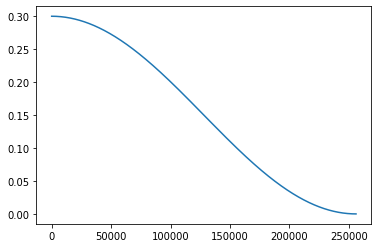

In [4]:
import matplotlib.pyplot as plt

plt.plot(ps)

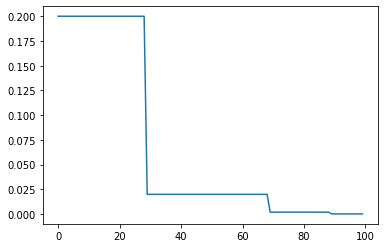

In [26]:
from dataclasses import dataclass
import torch``

@dataclass(init=True)
class Flags():
    base_learning_rate: float
    train_batch_size:int

global FLAGS
FLAGS = Flags(base_learning_rate=0.1, train_batch_size=512)

global LR_SCHEDULE
LR_SCHEDULE = [(1.0, 0), (0.1, 30), (0.01, 70), (0.001, 90), (.0001, 120)]

def lr_schedule(current_epoch):
    """Computes learning rate schedule."""
    scaled_lr = FLAGS.base_learning_rate * (FLAGS.train_batch_size / 256.0)
    decay_rate = (
            scaled_lr * LR_SCHEDULE[0][0] * current_epoch / LR_SCHEDULE[0][1]
        ) 
    # print(decay_rate)
    for mult, start_epoch in LR_SCHEDULE:
        decay_rate = torch.where(current_epoch < start_epoch, decay_rate, scaled_lr * mult)
    return decay_rate


epochs = torch.arange(1,101)
lrs = []

for e in epochs:
    lrs.append(lr_schedule(e).item())

import matplotlib.pyplot as plt
plt.plot(lrs)

In [25]:
current_epoch=torch.tensor([1], dtype=torch.int8)
scaled_lr = FLAGS.base_learning_rate * (FLAGS.train_batch_size / 256.0)
decay_rate = (
        scaled_lr * LR_SCHEDULE[0][0] * current_epoch / LR_SCHEDULE[0][1]
    ) 
print(decay_rate)
for mult, start_epoch in LR_SCHEDULE:
        decay_rate = torch.where(current_epoch < start_epoch, decay_rate, scaled_lr * mult)
print(decay_rate)

tensor([inf])
tensor([1.6000])


In [18]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, _LRScheduler
from torch.optim import AdamW
import math
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import StepLrWithLinearWarmUp


In [1]:
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
from rigl_torch.models import ModelFactory
import hydra

with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=["dataset=cifar10", "model=wide_resnet22", "compute.distributed=False"])
cfg

net = ModelFactory.load_model("wide_resnet22", "cifar10")

INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering mnist for mnist dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering resnet18 for cifar10 dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering wide_resnet22 for cifar10 dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering cond_net for mnist dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering wide_resnet22 for imagenet dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering resnet18 for imagenet dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering resnet50 for imagenet dataset to ModelFactory...
/tmp/ipykernel_153204/82332062.py:6: UserWarning: 
The version_base parameter is not specif

In [4]:
import torchvision
cifar = torchvision.datasets.CIFAR10(root="../data/", download=True)

Files already downloaded and verified


In [21]:
len(cifar)

50000

In [22]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

def main(rank, cfg):
    cifar = torchvision.datasets.CIFAR10(root="../data/", download=True)
    device = torch.device(f"cuda:{rank}")
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        cifar, drop_last=True
    )
    train_loader = torch.utils.data.DataLoader(
        cifar,
        sampler=train_sampler,
        batch_size=128,
        shuffle=True,
    )
    print(f"Num samples in rank {rank}: {len(train_loader)*256}") 

    


mp.spawn(
    main,
    args=(cfg,),
    nprocs=2,
)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'main' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'main' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [5]:
train, test = get_dataloaders(cfg)

Files already downloaded and verified


In [6]:
cfg.training.batch_size

32

In [7]:
len(train)

1562

In [8]:
len(train.dataset)

50000

In [9]:
len(train.dataset) / cfg.training.batch_size

1562.5

In [10]:
for imgs,labels in train:
    break

In [2]:
import torch
from rigl_torch.optim import get_lr_scheduler, get_optimizer
optim = get_optimizer(cfg, net, None)
lr_scheduler = get_lr_scheduler(cfg, optim, None)



# adamw1 = AdamW(net.parameters(), lr=0.001)
# adamw2 = AdamW(net.parameters(), lr=0.001)
# linear_step = torch.optim.lr_scheduler.StepLR(adamw2, step_size=30000, gamma=0.2)
# cawr = CosineAnnealingWarmRestarts(optimizer=adamw1, T_0=20, T_mult=2)
# ca = CosineAnnealingLR(optimizer=adamw2, T_max=T_max)
# adamw3 = AdamW(net.parameters(), lr=0.001)
# test= CosineAnnealingWithLinearWarmUp(optimizer=adamw3, T_max=T_max, warm_up_steps=50, lr=0.001)

In [12]:
# lr_scheduler.get_last_lr()

In [13]:
# lr_scheduler.step_size

In [3]:
%matplotlib inline
lrs=[]
step_lrs=[]
# from torch.optim.lr_scheduler import StepLR
# step_scheduler = StepLR(optim, step_size=30, gamma=0.1)
for epoch in range(0,100):
    # lr = [group["lr"] for group in optim.param_groups][0]
    lr=lr_scheduler.get_last_lr()[0]
    lrs.append(lr)
    lr_scheduler.step()
    # lr = [group["lr"] for group in optim.param_groups][0]
    # step_lrs.append(lr)
    # step_scheduler.step()

# for x in range(T_max):
#     lr1 = cawr.get_last_lr()
#     warm_restart_lrs.append(lr1)
#     cawr.step()
#     lr2 = linear_step.get_last_lr()
#     linear_step_lrs.append(lr2)
#     linear_step.step()
    # combined.append(lr1[0] * lr2[0]*1000)
    # lr3 = test.get_last_lr()
    # linear_warmup.append(lr3)
    # test.step()

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:/home/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.020000000000000004 @ epoch 30
INFO:/home/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.0020000000000000005 @ epoch 70
INFO:/home/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00020000000000000006 @ epoch 90


In [5]:
lrs[0:6]

[1e-06, 0.050000750000000004, 0.1000005, 0.15000025, 0.2, 0.2]

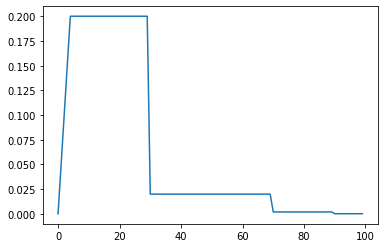

In [4]:
import matplotlib.pyplot as plt

plt.plot(lrs)
# plt.plot(step_lrs)
# plt.plot(combined)
# plt.plot(linear_warmup)

In [16]:
lrs[28:32]

[1.6, 1.6, 0.16000000000000003, 0.16000000000000003]

In [17]:
lrs[31]

0.16000000000000003

In [ ]:
from rigl_torch.models import get_model
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
import hydra

In [ ]:
with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=[])
cfg

In [ ]:
def print_image_shape(module, input, output):
    print(f"Module {module._get_name()}")
    print(f"input shape: {input[0].shape} output shape: {output.shape}")
    return output